### How many games does a team needs to win to be crowned champions?

First we will need to import the standing tables

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from library import (
    get_squad_as_index,
    remove_unnamed_cols,
    clean_opp_df,
    clean_main_df,
    merge_dfs,
    get_multiple_regular_seasons_tables,
    get_single_season_league_data,
    edit_gk_tables,
)

In [2]:
reg_seasons = get_multiple_regular_seasons_tables(country="England", tier=1, year_range="2012-2022")

In [11]:
my_dict = reg_seasons.copy()

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

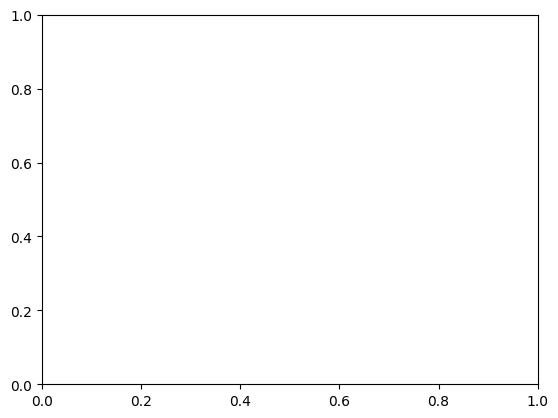

In [13]:

years = list(my_dict.keys())

for key in my_dict.keys():
    df = my_dict[key]
    df = df[df['Rk'] <= 4] # only include data with RK <= 4
    for rk in df['Rk'].unique():
        plt.plot(years, df[df['Rk'] == rk]['Pts'], label = f'RK {rk}')

plt.xlabel('Years')
plt.ylabel('Points')
plt.legend()
plt.grid(linestyle="dashed")
plt.show()


In [6]:

# filter the DataFrames in the dictionary by the Rk column
filtered_dict = {year: df[df['Rk'] <= 4] for year, df in reg_seasons.items()}

# extract the Pts column for each year
pts = {year: df['Pts'] for year, df in filtered_dict.items()}

fig = go.Figure()
fig.add_trace(go.Bar(x=list(pts.keys()), y=list(pts.values())))
fig.update_layout(title='Points by year', xaxis_title='Years', yaxis_title='Points')
fig.show()


In [14]:
import plotly.graph_objects as go

years = list(my_dict.keys())

data = []
for key in my_dict.keys():
    df = my_dict[key]
    df = df[df['Rk'] <= 4] # only include data with RK <= 4
    for rk in df['Rk'].unique():
        data.append(go.Scatter(x=years, y=df[df['Rk'] == rk]['Pts'], mode='lines', name=f'RK {rk}'))

layout = go.Layout(
    xaxis=dict(title='Years'),
    yaxis=dict(title='Points')
)

fig = go.Figure(data=data, layout=layout)
fig.show()
